In [1]:
from bs4 import BeautifulSoup
import requests

In [2]:
import time
import os

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [5]:
from sklearn.preprocessing import normalize

In [6]:
pd.options.display.max_columns = None

In [7]:
# Takes in year and returns the last 2 digits that represent its year
# Examples:
# 2013 -> '13'
# 1999 -> '99'
# 2001 -> '01'
def get_last_year_digits(year):
    return str(year)[-2:]

In [37]:
# Takes in a DataFrame for regular season statistics of the Four Factors and normalizes it (using sklearn)
calc_cols = ['eFG%', 'FTARate', 'TOV%', 'OREB%', 'OppeFG%', 'OppFTARate', 'OppTOV%', 'OppDREB%']
rel_cols = ['Rel' + col for col in calc_cols]
def add_rel_cols(df):
    for col in calc_cols:
        new_col = 'Rel' + col
        df[new_col] = normalize([df[col]])[0]

In [9]:
# Create the csv folder if it's not there
if (not os.path.isdir('csv')):
    os.mkdir('csv')

## Preparing Data

### Regular Season

In [10]:
if (not os.path.isdir('csv/regseason')):
    os.mkdir('csv/regseason')

In [11]:
# Get URL from Basketball Reference based on year
get_basketball_reference_url = lambda x: f'https://www.basketball-reference.com/leagues/NBA_{x}.html'

In [12]:
for year in range(1984, 2023):
    url = get_basketball_reference_url(year)
    season_year_end = get_last_year_digits(year)
    season_year_start = get_last_year_digits(year - 1)
    
    reg_season = requests.get(url)
    soup = BeautifulSoup(reg_season.content)
    advanced = soup.find(id='advanced-team') # Grabs the table I want
    
    df = pd.read_html(advanced.prettify())[0] # Found this nifty little function that I should've used before
    
    # Cleans up the MultiIndex that the DataFrame is created with
    top_unnamed = [f'Unnamed: {x}_level_0' for x in range(len(df.columns))] 
    col_clean = dict.fromkeys(top_unnamed, '')
    col_clean['Offense Four Factors'] = ''
    col_clean['Defense Four Factors'] = 'Opp'
    
    df = df.rename(columns=col_clean).drop(columns=[('', 'Unnamed: 17_level_1'), ('', 'Unnamed: 22_level_1'), ('', 'Unnamed: 27_level_1')])
    df.columns = [''.join(col) for col in df.columns]
    
    # Renames FT/FGA to FTARate and RB to REB to not have to change old code
    df = df.rename(columns={'FT/FGA': 'FTARate', 'OppFT/FGA': 'OppFTARate', 'ORB%': 'OREB%', 'OppDRB%': 'OppDREB%' })
    
    # Removes "League Average" row
    df = df[df['Rk'] == df['Rk']]
    
    # Cleans up decimals where they don't need to be
    df = df.astype({'Rk': int, 'W': int, 'L': int})
    
    # Removes whether a team made the playoffs
    df['Made Playoffs'] = df['Team'].str.endswith('*')
    df['Team'] = df['Team'].str.removesuffix('*')
    df['Team'] = df['Team'].str.rstrip()
    
    # Outputs to CSV file
    csv_output = f'csv/regseason/{season_year_start}_{season_year_end}.csv'
    df.to_csv(csv_output)
    print(f'Wrote to {csv_output}.')
    
    # Tries not to trigger Basketball Reference's rate limiter
    time.sleep(5)

Wrote to csv/regseason/83_84.csv.
Wrote to csv/regseason/84_85.csv.
Wrote to csv/regseason/85_86.csv.
Wrote to csv/regseason/86_87.csv.
Wrote to csv/regseason/87_88.csv.
Wrote to csv/regseason/88_89.csv.
Wrote to csv/regseason/89_90.csv.
Wrote to csv/regseason/90_91.csv.
Wrote to csv/regseason/91_92.csv.
Wrote to csv/regseason/92_93.csv.
Wrote to csv/regseason/93_94.csv.
Wrote to csv/regseason/94_95.csv.
Wrote to csv/regseason/95_96.csv.
Wrote to csv/regseason/96_97.csv.
Wrote to csv/regseason/97_98.csv.
Wrote to csv/regseason/98_99.csv.
Wrote to csv/regseason/99_00.csv.
Wrote to csv/regseason/00_01.csv.
Wrote to csv/regseason/01_02.csv.
Wrote to csv/regseason/02_03.csv.
Wrote to csv/regseason/03_04.csv.
Wrote to csv/regseason/04_05.csv.
Wrote to csv/regseason/05_06.csv.
Wrote to csv/regseason/06_07.csv.
Wrote to csv/regseason/07_08.csv.
Wrote to csv/regseason/08_09.csv.
Wrote to csv/regseason/09_10.csv.
Wrote to csv/regseason/10_11.csv.
Wrote to csv/regseason/11_12.csv.
Wrote to csv/r

#### Graphing Relative Data

In [19]:
table = pd.read_csv('csv/regseason/21_22.csv')

In [20]:
add_rel_cols(table)

In [21]:
xpoints = list(range(1, 31))
xpoints.reverse()
# Generating x-values for rankings

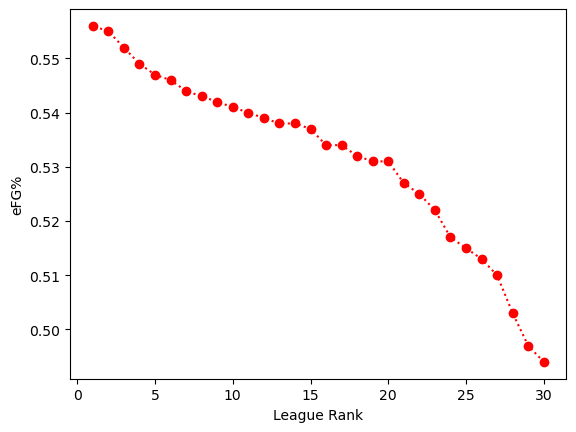

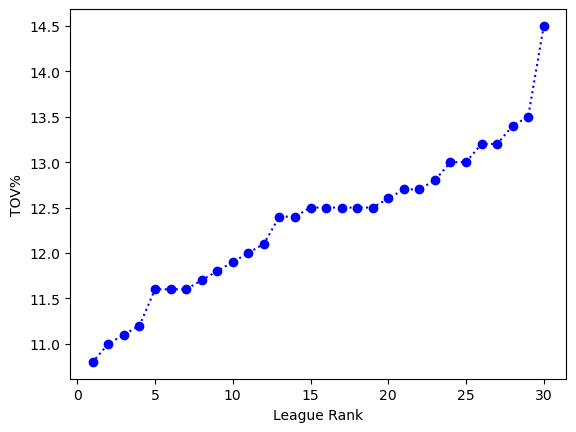

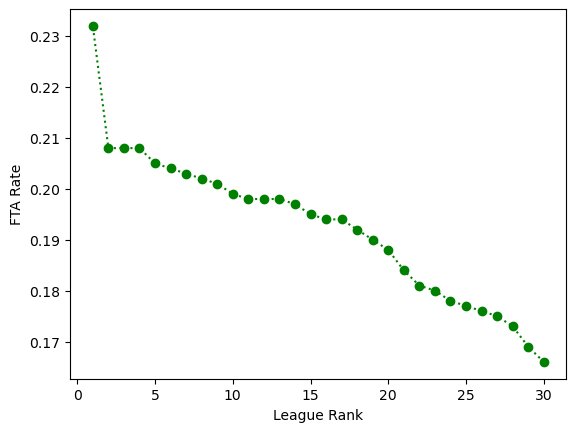

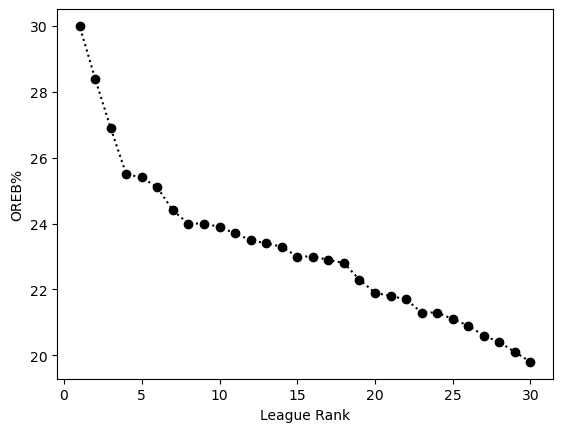

In [22]:
# Offensive Rankings
efg_points = table['eFG%'].sort_values(ascending = True)
tov_points = table['TOV%'].sort_values(ascending = False)
# The best teams turn the ball over less, so you reverse this one for a more accurate view at who is good at mitigating TOs.
fta_points = table['FTARate'].sort_values(ascending = True)
oreb_points = table['OREB%'].sort_values(ascending = True)
plt.plot(xpoints, efg_points, 'o:r')
plt.xlabel('League Rank')
plt.ylabel('eFG%')
plt.show()
plt.plot(xpoints, tov_points, 'o:b')
plt.xlabel('League Rank')
plt.ylabel('TOV%')
plt.show()
plt.plot(xpoints, fta_points, 'o:g')
plt.xlabel('League Rank')
plt.ylabel('FTA Rate')
plt.show()
plt.plot(xpoints, oreb_points, 'o:k')
plt.xlabel('League Rank')
plt.ylabel('OREB%')
plt.show()

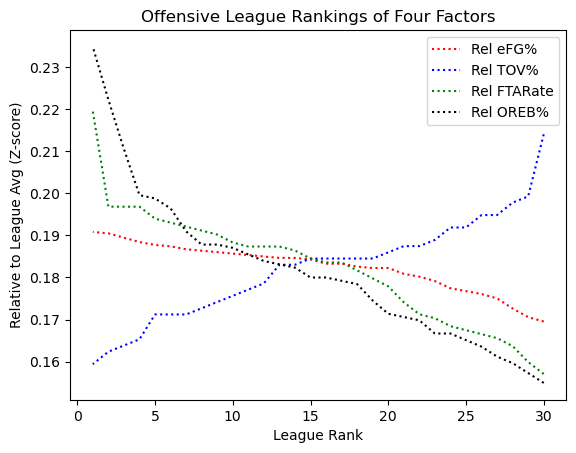

In [23]:
# red = eFG%
# blue = TOV%
# green = FTA Rate
# black = OREB%
rel_efg_points = table['ReleFG%'].sort_values(ascending = True)
rel_tov_points = table['RelTOV%'].sort_values(ascending = False)
# Multiplying the z-score by -1 so that the teams w/ the greatest TOV% have the worse z-score
rel_fta_points = table['RelFTARate'].sort_values(ascending = True)
rel_oreb_points = table['RelOREB%'].sort_values(ascending = True)
plt.plot(xpoints, rel_efg_points, ':r', label = 'Rel eFG%')
plt.plot(xpoints, rel_tov_points, ':b', label = 'Rel TOV%')
plt.plot(xpoints, rel_fta_points, ':g', label = 'Rel FTARate')
plt.plot(xpoints, rel_oreb_points, ':k', label = 'Rel OREB%')
plt.title('Offensive League Rankings of Four Factors')
plt.xlabel('League Rank')
plt.ylabel('Relative to League Avg (Z-score)')
plt.legend()
plt.show()

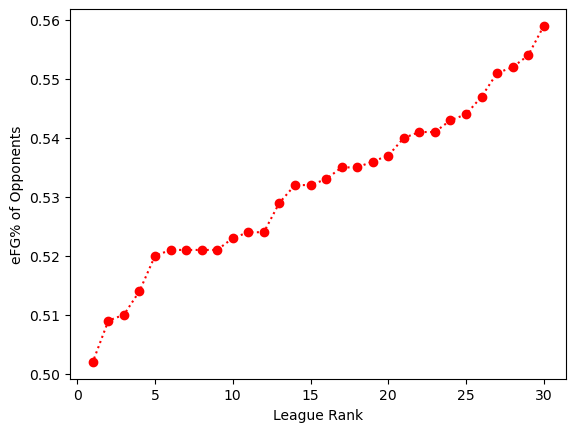

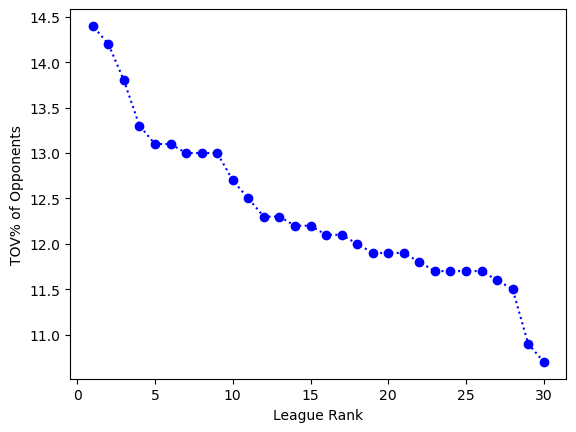

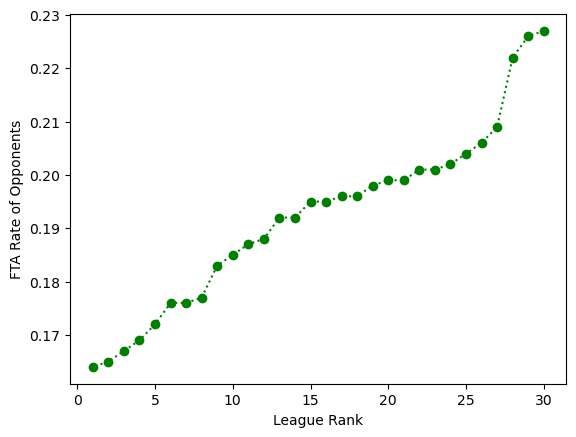

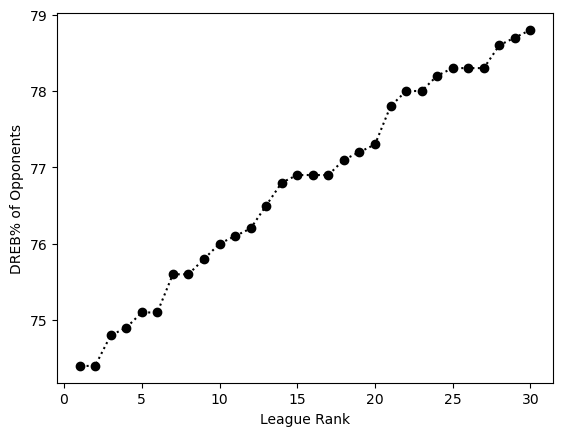

In [24]:
# Defensive Rankings
opp_efg_points = table['OppeFG%'].sort_values(ascending = False)
opp_tov_points = table['OppTOV%'].sort_values(ascending = True)
opp_fta_points = table['OppFTARate'].sort_values(ascending = False)
opp_dreb_points = table['OppDREB%'].sort_values(ascending = False)
plt.plot(xpoints, opp_efg_points, 'o:r')
plt.xlabel('League Rank')
plt.ylabel('eFG% of Opponents')
plt.show()
plt.plot(xpoints, opp_tov_points, 'o:b')
plt.xlabel('League Rank')
plt.ylabel('TOV% of Opponents')
plt.show()
plt.plot(xpoints, opp_fta_points, 'o:g')
plt.xlabel('League Rank')
plt.ylabel('FTA Rate of Opponents')
plt.show()
plt.plot(xpoints, opp_dreb_points, 'o:k')
plt.xlabel('League Rank')
plt.ylabel('DREB% of Opponents')
plt.show()

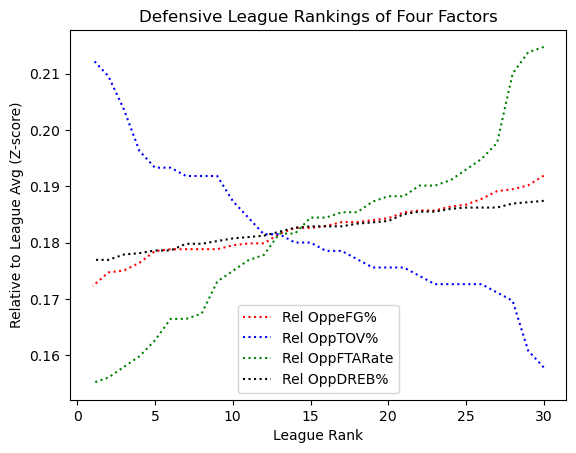

In [25]:
rel_opp_efg_points = table['RelOppeFG%'].sort_values(ascending = False)
rel_opp_fta_points = table['RelOppFTARate'].sort_values(ascending = False)
rel_opp_tov_points = table['RelOppTOV%'].sort_values(ascending = True)
rel_opp_dreb_points = table['RelOppDREB%'].sort_values(ascending = False)

plt.plot(xpoints, rel_opp_efg_points, ':r', label = 'Rel OppeFG%')
plt.plot(xpoints, rel_opp_tov_points, ':b', label = 'Rel OppTOV%')
plt.plot(xpoints, rel_opp_fta_points, ':g', label = 'Rel OppFTARate')
plt.plot(xpoints, rel_opp_dreb_points, ':k', label = 'Rel OppDREB%')

plt.title('Defensive League Rankings of Four Factors')
plt.xlabel('League Rank')
plt.ylabel('Relative to League Avg (Z-score)')
plt.legend()
plt.show()

### Playoffs

In [26]:
if (not os.path.isdir('csv/playoffs')):
    os.mkdir('csv/playoffs')

In [27]:
get_basketball_reference_url_playoffs = lambda x: f'https://www.basketball-reference.com/playoffs/NBA_{x}.html#advanced-team'

In [28]:
for year in range(1984, 2023):
    url = get_basketball_reference_url_playoffs(year)
    season_year_end = get_last_year_digits(year)
    season_year_start = get_last_year_digits(year - 1)
    
    playoffs = requests.get(url)
    psoup = BeautifulSoup(playoffs.content)
    ptable = psoup.find(id='advanced-team')
    
    pdf = pd.read_html(ptable.prettify())[0]
    
    top_unnamed = [f'Unnamed: {x}_level_0' for x in range(len(pdf.columns))] 
    col_clean = dict.fromkeys(top_unnamed, '')
    col_clean['Offense Four Factors'] = ''
    col_clean['Defense Four Factors'] = 'Opp'
    
    pdf = pdf.rename(columns=col_clean).drop(columns=[('', 'Unnamed: 15_level_1'), ('', 'Unnamed: 20_level_1')])
    pdf.columns = [''.join(col) for col in pdf.columns]
    
    pdf = pdf[pdf['Rk'] == pdf['Rk']]
    pdf = pdf.astype({ 'Rk': int, 'W': int, 'L': int })
    
    pdf = pdf.rename(columns={'Tm': 'Team'})
    
    # Outputs to CSV file
    csv_output = f'csv/playoffs/{season_year_start}_{season_year_end}.csv'
    pdf.to_csv(csv_output)
    print(f'Wrote to {csv_output}.')
    
    # Tries not to trigger Basketball Reference's rate limiter
    time.sleep(5)

Wrote to csv/playoffs/83_84.csv.
Wrote to csv/playoffs/84_85.csv.
Wrote to csv/playoffs/85_86.csv.
Wrote to csv/playoffs/86_87.csv.
Wrote to csv/playoffs/87_88.csv.
Wrote to csv/playoffs/88_89.csv.
Wrote to csv/playoffs/89_90.csv.
Wrote to csv/playoffs/90_91.csv.
Wrote to csv/playoffs/91_92.csv.
Wrote to csv/playoffs/92_93.csv.
Wrote to csv/playoffs/93_94.csv.
Wrote to csv/playoffs/94_95.csv.
Wrote to csv/playoffs/95_96.csv.
Wrote to csv/playoffs/96_97.csv.
Wrote to csv/playoffs/97_98.csv.
Wrote to csv/playoffs/98_99.csv.
Wrote to csv/playoffs/99_00.csv.
Wrote to csv/playoffs/00_01.csv.
Wrote to csv/playoffs/01_02.csv.
Wrote to csv/playoffs/02_03.csv.
Wrote to csv/playoffs/03_04.csv.
Wrote to csv/playoffs/04_05.csv.
Wrote to csv/playoffs/05_06.csv.
Wrote to csv/playoffs/06_07.csv.
Wrote to csv/playoffs/07_08.csv.
Wrote to csv/playoffs/08_09.csv.
Wrote to csv/playoffs/09_10.csv.
Wrote to csv/playoffs/10_11.csv.
Wrote to csv/playoffs/11_12.csv.
Wrote to csv/playoffs/12_13.csv.
Wrote to c

## Test Merges

In [29]:
playoffs_22 = pd.read_csv('csv/playoffs/21_22.csv')
reg_22 = pd.read_csv('csv/regseason/21_22.csv')

In [30]:
playoffs_wins = playoffs_22[['Team', 'W', 'L', 'W/L%']]
playoffs_wins = playoffs_wins.rename(columns={'W': 'PlayoffW', 'L': 'PlayoffL', 'W/L%': 'PlayoffWIN%'})
playoffs_wins['PlayoffGP'] = playoffs_wins['PlayoffW'] + playoffs_wins['PlayoffL']
playoffs_wins

,Team,PlayoffW,PlayoffL,PlayoffWIN%,PlayoffGP
0,Golden State Warriors,16,6,0.727,22
1,Miami Heat,11,7,0.611,18
2,Boston Celtics,14,10,0.583,24
3,Memphis Grizzlies,6,6,0.500,12
4,Milwaukee Bucks,7,5,0.583,12
5,Dallas Mavericks,9,9,0.500,18
6,Philadelphia 76ers,6,6,0.500,12
7,Phoenix Suns,7,6,0.538,13
8,New Orleans Pelicans,2,4,0.333,6
9,Brooklyn Nets,0,4,0.000,4


In [31]:
add_rel_cols(reg_22)

In [32]:
reg_22

,Unnamed: 0,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,OREB%,FTARate,OppeFG%,OppTOV%,OppDREB%,OppFTARate,Arena,Attend.,Attend./G,Made Playoffs,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppDREB%
0,0,1,Boston Celtics,26.1,51,31,59,23,7.28,-0.26,7.02,114.4,106.9,7.5,96.6,0.239,0.425,0.578,0.542,12.4,24.0,0.195,0.502,12.5,77.3,0.183,TD Garden,785396,19156,True,0.186012,0.184507,0.183015,0.187811,0.172317,0.173096,0.184445,0.183846
1,1,2,Phoenix Suns,27.5,64,18,59,23,7.50,-0.56,6.94,114.8,107.3,7.5,99.8,0.221,0.354,0.581,0.549,11.6,22.3,0.176,0.510,13.0,77.1,0.195,Phoenix Suns Arena,663171,16175,True,0.188415,0.166529,0.171208,0.174508,0.175063,0.184447,0.191822,0.183371
2,2,3,Utah Jazz,29.3,49,33,56,26,6.04,-0.37,5.67,116.7,110.5,6.2,97.1,0.271,0.468,0.589,0.555,12.7,25.4,0.208,0.521,10.9,78.3,0.164,Vivint Smart Home Arena,750546,18306,True,0.190474,0.196807,0.187443,0.198767,0.178839,0.155124,0.160836,0.186225
3,3,4,Memphis Grizzlies,24.0,56,26,55,27,5.68,-0.32,5.37,114.6,109.0,5.6,100.3,0.245,0.346,0.553,0.522,11.2,30.0,0.180,0.523,13.3,77.8,0.195,FedEx Forum,646785,15775,True,0.179149,0.170314,0.165304,0.234764,0.179525,0.184447,0.196249,0.185035
4,4,5,Golden State Warriors,27.6,53,29,55,27,5.54,-0.02,5.52,112.5,106.9,5.6,98.4,0.235,0.456,0.582,0.552,13.5,22.8,0.181,0.509,13.0,78.7,0.201,Chase Center,740624,18064,True,0.189444,0.171260,0.199250,0.178420,0.174719,0.190122,0.191822,0.187176
5,5,6,Miami Heat,28.2,53,29,53,29,4.45,-0.22,4.23,113.7,109.1,4.6,95.9,0.252,0.422,0.584,0.547,13.4,23.5,0.204,0.524,13.8,78.0,0.209,FTX Arena,804761,19628,True,0.187728,0.193023,0.197774,0.183898,0.179868,0.197689,0.203627,0.185511
6,6,7,Dallas Mavericks,26.7,52,30,50,32,3.30,-0.18,3.12,112.8,109.4,3.4,95.4,0.249,0.439,0.572,0.538,11.7,21.3,0.192,0.521,12.2,78.0,0.185,American Airlines Center,808037,19708,True,0.184640,0.181668,0.172683,0.166682,0.178839,0.174988,0.180018,0.185511
7,7,8,Milwaukee Bucks,28.5,51,31,49,33,3.35,-0.14,3.22,115.1,111.8,3.3,99.9,0.257,0.430,0.580,0.546,11.9,23.0,0.199,0.536,11.6,78.6,0.165,Fiserv Forum,715581,17453,True,0.187385,0.188292,0.175635,0.179985,0.183987,0.156070,0.171165,0.186938
8,8,9,Philadelphia 76ers,26.8,51,31,48,34,2.61,-0.04,2.57,113.5,110.8,2.7,96.2,0.282,0.376,0.578,0.534,11.6,20.1,0.232,0.524,12.1,76.8,0.192,Wells Fargo Center,846867,20655,True,0.183267,0.219516,0.171208,0.157292,0.179868,0.181609,0.178542,0.182657
9,9,10,Minnesota Timberwolves,24.2,46,36,48,34,2.63,-0.10,2.53,114.3,111.7,2.6,100.9,0.254,0.454,0.573,0.539,12.4,24.4,0.198,0.535,14.2,74.9,0.227,Target Center,657148,16028,True,0.184983,0.187346,0.183015,0.190941,0.183644,0.214715,0.209529,0.178138


### Only Playoff Teams

#### Merging Datasets

In [33]:
merge2 = reg_22.merge(playoffs_wins, how='inner', left_on = 'Team', right_on = 'Team')
# Inner Join excludes all teams that didn't make the playoffs
merge2 = merge2.fillna(0)
# Fill in the NaN's so that we can do math with the non-playoff teams
merge2

,Unnamed: 0,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,OREB%,FTARate,OppeFG%,OppTOV%,OppDREB%,OppFTARate,Arena,Attend.,Attend./G,Made Playoffs,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppDREB%,PlayoffW,PlayoffL,PlayoffWIN%,PlayoffGP
0,0,1,Boston Celtics,26.1,51,31,59,23,7.28,-0.26,7.02,114.4,106.9,7.5,96.6,0.239,0.425,0.578,0.542,12.4,24.0,0.195,0.502,12.5,77.3,0.183,TD Garden,785396,19156,True,0.186012,0.184507,0.183015,0.187811,0.172317,0.173096,0.184445,0.183846,14,10,0.583,24
1,1,2,Phoenix Suns,27.5,64,18,59,23,7.50,-0.56,6.94,114.8,107.3,7.5,99.8,0.221,0.354,0.581,0.549,11.6,22.3,0.176,0.510,13.0,77.1,0.195,Phoenix Suns Arena,663171,16175,True,0.188415,0.166529,0.171208,0.174508,0.175063,0.184447,0.191822,0.183371,7,6,0.538,13
2,2,3,Utah Jazz,29.3,49,33,56,26,6.04,-0.37,5.67,116.7,110.5,6.2,97.1,0.271,0.468,0.589,0.555,12.7,25.4,0.208,0.521,10.9,78.3,0.164,Vivint Smart Home Arena,750546,18306,True,0.190474,0.196807,0.187443,0.198767,0.178839,0.155124,0.160836,0.186225,2,4,0.333,6
3,3,4,Memphis Grizzlies,24.0,56,26,55,27,5.68,-0.32,5.37,114.6,109.0,5.6,100.3,0.245,0.346,0.553,0.522,11.2,30.0,0.180,0.523,13.3,77.8,0.195,FedEx Forum,646785,15775,True,0.179149,0.170314,0.165304,0.234764,0.179525,0.184447,0.196249,0.185035,6,6,0.500,12
4,4,5,Golden State Warriors,27.6,53,29,55,27,5.54,-0.02,5.52,112.5,106.9,5.6,98.4,0.235,0.456,0.582,0.552,13.5,22.8,0.181,0.509,13.0,78.7,0.201,Chase Center,740624,18064,True,0.189444,0.171260,0.199250,0.178420,0.174719,0.190122,0.191822,0.187176,16,6,0.727,22
5,5,6,Miami Heat,28.2,53,29,53,29,4.45,-0.22,4.23,113.7,109.1,4.6,95.9,0.252,0.422,0.584,0.547,13.4,23.5,0.204,0.524,13.8,78.0,0.209,FTX Arena,804761,19628,True,0.187728,0.193023,0.197774,0.183898,0.179868,0.197689,0.203627,0.185511,11,7,0.611,18
6,6,7,Dallas Mavericks,26.7,52,30,50,32,3.30,-0.18,3.12,112.8,109.4,3.4,95.4,0.249,0.439,0.572,0.538,11.7,21.3,0.192,0.521,12.2,78.0,0.185,American Airlines Center,808037,19708,True,0.184640,0.181668,0.172683,0.166682,0.178839,0.174988,0.180018,0.185511,9,9,0.500,18
7,7,8,Milwaukee Bucks,28.5,51,31,49,33,3.35,-0.14,3.22,115.1,111.8,3.3,99.9,0.257,0.430,0.580,0.546,11.9,23.0,0.199,0.536,11.6,78.6,0.165,Fiserv Forum,715581,17453,True,0.187385,0.188292,0.175635,0.179985,0.183987,0.156070,0.171165,0.186938,7,5,0.583,12
8,8,9,Philadelphia 76ers,26.8,51,31,48,34,2.61,-0.04,2.57,113.5,110.8,2.7,96.2,0.282,0.376,0.578,0.534,11.6,20.1,0.232,0.524,12.1,76.8,0.192,Wells Fargo Center,846867,20655,True,0.183267,0.219516,0.171208,0.157292,0.179868,0.181609,0.178542,0.182657,6,6,0.500,12
9,9,10,Minnesota Timberwolves,24.2,46,36,48,34,2.63,-0.10,2.53,114.3,111.7,2.6,100.9,0.254,0.454,0.573,0.539,12.4,24.4,0.198,0.535,14.2,74.9,0.227,Target Center,657148,16028,True,0.184983,0.187346,0.183015,0.190941,0.183644,0.214715,0.209529,0.178138,2,4,0.333,6


In [34]:
merge2['Champ%'] = merge2['PlayoffW'] / merge2['PlayoffW'].max()
merge2['PlayoffGP'] = merge2['PlayoffGP'].astype('int64')
merge2['PlayoffW'] = merge2['PlayoffW'].astype('int64')
merge2['PlayoffL'] = merge2['PlayoffL'].astype('int64')

In [35]:
merge2

,Unnamed: 0,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,OREB%,FTARate,OppeFG%,OppTOV%,OppDREB%,OppFTARate,Arena,Attend.,Attend./G,Made Playoffs,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppDREB%,PlayoffW,PlayoffL,PlayoffWIN%,PlayoffGP,Champ%
0,0,1,Boston Celtics,26.1,51,31,59,23,7.28,-0.26,7.02,114.4,106.9,7.5,96.6,0.239,0.425,0.578,0.542,12.4,24.0,0.195,0.502,12.5,77.3,0.183,TD Garden,785396,19156,True,0.186012,0.184507,0.183015,0.187811,0.172317,0.173096,0.184445,0.183846,14,10,0.583,24,0.8750
1,1,2,Phoenix Suns,27.5,64,18,59,23,7.50,-0.56,6.94,114.8,107.3,7.5,99.8,0.221,0.354,0.581,0.549,11.6,22.3,0.176,0.510,13.0,77.1,0.195,Phoenix Suns Arena,663171,16175,True,0.188415,0.166529,0.171208,0.174508,0.175063,0.184447,0.191822,0.183371,7,6,0.538,13,0.4375
2,2,3,Utah Jazz,29.3,49,33,56,26,6.04,-0.37,5.67,116.7,110.5,6.2,97.1,0.271,0.468,0.589,0.555,12.7,25.4,0.208,0.521,10.9,78.3,0.164,Vivint Smart Home Arena,750546,18306,True,0.190474,0.196807,0.187443,0.198767,0.178839,0.155124,0.160836,0.186225,2,4,0.333,6,0.1250
3,3,4,Memphis Grizzlies,24.0,56,26,55,27,5.68,-0.32,5.37,114.6,109.0,5.6,100.3,0.245,0.346,0.553,0.522,11.2,30.0,0.180,0.523,13.3,77.8,0.195,FedEx Forum,646785,15775,True,0.179149,0.170314,0.165304,0.234764,0.179525,0.184447,0.196249,0.185035,6,6,0.500,12,0.3750
4,4,5,Golden State Warriors,27.6,53,29,55,27,5.54,-0.02,5.52,112.5,106.9,5.6,98.4,0.235,0.456,0.582,0.552,13.5,22.8,0.181,0.509,13.0,78.7,0.201,Chase Center,740624,18064,True,0.189444,0.171260,0.199250,0.178420,0.174719,0.190122,0.191822,0.187176,16,6,0.727,22,1.0000
5,5,6,Miami Heat,28.2,53,29,53,29,4.45,-0.22,4.23,113.7,109.1,4.6,95.9,0.252,0.422,0.584,0.547,13.4,23.5,0.204,0.524,13.8,78.0,0.209,FTX Arena,804761,19628,True,0.187728,0.193023,0.197774,0.183898,0.179868,0.197689,0.203627,0.185511,11,7,0.611,18,0.6875
6,6,7,Dallas Mavericks,26.7,52,30,50,32,3.30,-0.18,3.12,112.8,109.4,3.4,95.4,0.249,0.439,0.572,0.538,11.7,21.3,0.192,0.521,12.2,78.0,0.185,American Airlines Center,808037,19708,True,0.184640,0.181668,0.172683,0.166682,0.178839,0.174988,0.180018,0.185511,9,9,0.500,18,0.5625
7,7,8,Milwaukee Bucks,28.5,51,31,49,33,3.35,-0.14,3.22,115.1,111.8,3.3,99.9,0.257,0.430,0.580,0.546,11.9,23.0,0.199,0.536,11.6,78.6,0.165,Fiserv Forum,715581,17453,True,0.187385,0.188292,0.175635,0.179985,0.183987,0.156070,0.171165,0.186938,7,5,0.583,12,0.4375
8,8,9,Philadelphia 76ers,26.8,51,31,48,34,2.61,-0.04,2.57,113.5,110.8,2.7,96.2,0.282,0.376,0.578,0.534,11.6,20.1,0.232,0.524,12.1,76.8,0.192,Wells Fargo Center,846867,20655,True,0.183267,0.219516,0.171208,0.157292,0.179868,0.181609,0.178542,0.182657,6,6,0.500,12,0.3750
9,9,10,Minnesota Timberwolves,24.2,46,36,48,34,2.63,-0.10,2.53,114.3,111.7,2.6,100.9,0.254,0.454,0.573,0.539,12.4,24.4,0.198,0.535,14.2,74.9,0.227,Target Center,657148,16028,True,0.184983,0.187346,0.183015,0.190941,0.183644,0.214715,0.209529,0.178138,2,4,0.333,6,0.1250


#### Creating Linear Model

In [38]:
inp, out = merge2[rel_cols], merge2['Champ%']
display(inp), display(out)

,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppDREB%
0,0.186012,0.184507,0.183015,0.187811,0.172317,0.173096,0.184445,0.183846
1,0.188415,0.166529,0.171208,0.174508,0.175063,0.184447,0.191822,0.183371
2,0.190474,0.196807,0.187443,0.198767,0.178839,0.155124,0.160836,0.186225
3,0.179149,0.170314,0.165304,0.234764,0.179525,0.184447,0.196249,0.185035
4,0.189444,0.171260,0.199250,0.178420,0.174719,0.190122,0.191822,0.187176
5,0.187728,0.193023,0.197774,0.183898,0.179868,0.197689,0.203627,0.185511
6,0.184640,0.181668,0.172683,0.166682,0.178839,0.174988,0.180018,0.185511
7,0.187385,0.188292,0.175635,0.179985,0.183987,0.156070,0.171165,0.186938
8,0.183267,0.219516,0.171208,0.157292,0.179868,0.181609,0.178542,0.182657
9,0.184983,0.187346,0.183015,0.190941,0.183644,0.214715,0.209529,0.178138


0     0.8750
1     0.4375
2     0.1250
3     0.3750
4     1.0000
5     0.6875
6     0.5625
7     0.4375
8     0.3750
9     0.1250
10    0.0625
11    0.1250
12    0.0625
13    0.0000
14    0.0625
15    0.1250
Name: Champ%, dtype: float64

(None, None)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(inp, out, test_size=0.3)

In [40]:
small_lm1 = LinearRegression()
small_lm1.fit(x_train, y_train)

LinearRegression()

In [41]:
small_lm1.intercept_

1.9782493209265808

In [42]:
list(zip(rel_cols, small_lm1.coef_))

[('ReleFG%', -9.987008871378267),
 ('RelFTARate', -1.4932758602515082),
 ('RelTOV%', 6.284344339885352),
 ('RelOREB%', -6.302853577669146),
 ('RelOppeFG%', -31.265178873682338),
 ('RelOppFTARate', -11.809428170036679),
 ('RelOppTOV%', 19.015773392212616),
 ('RelOppDREB%', 26.32504558715343)]

In [43]:
y_pred_small_lm1 = small_lm1.predict(x_test)

In [44]:
pd.DataFrame({'Predicted': y_pred_small_lm1, 'Actual': y_test, 'Difference': y_pred_small_lm1 - y_test})

,Predicted,Actual,Difference
11,0.408887,0.1250,0.283887
5,0.696468,0.6875,0.008968
0,0.726850,0.8750,-0.148150
9,0.194249,0.1250,0.069249
10,0.264722,0.0625,0.202222


In [45]:
mean_ab_err = metrics.mean_absolute_error(y_test, y_pred_small_lm1)
mean_sq_err = metrics.mean_squared_error(y_test, y_pred_small_lm1)
root_mean_sq_err = np.sqrt(metrics.mean_squared_error(y_test, y_pred_small_lm1))

print('R squared: {:.2f}'.format(small_lm1.score(inp,out)*100))
print('Mean Absolute Error:', mean_ab_err)
print('Mean Square Error:', mean_sq_err)
print('Root Mean Square Error:', root_mean_sq_err)

R squared: 80.49
Mean Absolute Error: 0.14249523211573556
Mean Square Error: 0.029661966247589544
Root Mean Square Error: 0.17222649693815859


### Including Every Team

In [46]:
merge = reg_22.merge(playoffs_wins, how='outer', left_on = 'Team', right_on = 'Team')
# Outer Join allows all teams to be included in the data set
merge = merge.fillna(0)
# Fill in the NaN's so that we can do math with the non-playoff teams
merge

,Unnamed: 0,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,OREB%,FTARate,OppeFG%,OppTOV%,OppDREB%,OppFTARate,Arena,Attend.,Attend./G,Made Playoffs,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppDREB%,PlayoffW,PlayoffL,PlayoffWIN%,PlayoffGP
0,0,1,Boston Celtics,26.1,51,31,59,23,7.28,-0.26,7.02,114.4,106.9,7.5,96.6,0.239,0.425,0.578,0.542,12.4,24.0,0.195,0.502,12.5,77.3,0.183,TD Garden,785396,19156,True,0.186012,0.184507,0.183015,0.187811,0.172317,0.173096,0.184445,0.183846,14.0,10.0,0.583,24.0
1,1,2,Phoenix Suns,27.5,64,18,59,23,7.50,-0.56,6.94,114.8,107.3,7.5,99.8,0.221,0.354,0.581,0.549,11.6,22.3,0.176,0.510,13.0,77.1,0.195,Phoenix Suns Arena,663171,16175,True,0.188415,0.166529,0.171208,0.174508,0.175063,0.184447,0.191822,0.183371,7.0,6.0,0.538,13.0
2,2,3,Utah Jazz,29.3,49,33,56,26,6.04,-0.37,5.67,116.7,110.5,6.2,97.1,0.271,0.468,0.589,0.555,12.7,25.4,0.208,0.521,10.9,78.3,0.164,Vivint Smart Home Arena,750546,18306,True,0.190474,0.196807,0.187443,0.198767,0.178839,0.155124,0.160836,0.186225,2.0,4.0,0.333,6.0
3,3,4,Memphis Grizzlies,24.0,56,26,55,27,5.68,-0.32,5.37,114.6,109.0,5.6,100.3,0.245,0.346,0.553,0.522,11.2,30.0,0.180,0.523,13.3,77.8,0.195,FedEx Forum,646785,15775,True,0.179149,0.170314,0.165304,0.234764,0.179525,0.184447,0.196249,0.185035,6.0,6.0,0.500,12.0
4,4,5,Golden State Warriors,27.6,53,29,55,27,5.54,-0.02,5.52,112.5,106.9,5.6,98.4,0.235,0.456,0.582,0.552,13.5,22.8,0.181,0.509,13.0,78.7,0.201,Chase Center,740624,18064,True,0.189444,0.171260,0.199250,0.178420,0.174719,0.190122,0.191822,0.187176,16.0,6.0,0.727,22.0
5,5,6,Miami Heat,28.2,53,29,53,29,4.45,-0.22,4.23,113.7,109.1,4.6,95.9,0.252,0.422,0.584,0.547,13.4,23.5,0.204,0.524,13.8,78.0,0.209,FTX Arena,804761,19628,True,0.187728,0.193023,0.197774,0.183898,0.179868,0.197689,0.203627,0.185511,11.0,7.0,0.611,18.0
6,6,7,Dallas Mavericks,26.7,52,30,50,32,3.30,-0.18,3.12,112.8,109.4,3.4,95.4,0.249,0.439,0.572,0.538,11.7,21.3,0.192,0.521,12.2,78.0,0.185,American Airlines Center,808037,19708,True,0.184640,0.181668,0.172683,0.166682,0.178839,0.174988,0.180018,0.185511,9.0,9.0,0.500,18.0
7,7,8,Milwaukee Bucks,28.5,51,31,49,33,3.35,-0.14,3.22,115.1,111.8,3.3,99.9,0.257,0.430,0.580,0.546,11.9,23.0,0.199,0.536,11.6,78.6,0.165,Fiserv Forum,715581,17453,True,0.187385,0.188292,0.175635,0.179985,0.183987,0.156070,0.171165,0.186938,7.0,5.0,0.583,12.0
8,8,9,Philadelphia 76ers,26.8,51,31,48,34,2.61,-0.04,2.57,113.5,110.8,2.7,96.2,0.282,0.376,0.578,0.534,11.6,20.1,0.232,0.524,12.1,76.8,0.192,Wells Fargo Center,846867,20655,True,0.183267,0.219516,0.171208,0.157292,0.179868,0.181609,0.178542,0.182657,6.0,6.0,0.500,12.0
9,9,10,Minnesota Timberwolves,24.2,46,36,48,34,2.63,-0.10,2.53,114.3,111.7,2.6,100.9,0.254,0.454,0.573,0.539,12.4,24.4,0.198,0.535,14.2,74.9,0.227,Target Center,657148,16028,True,0.184983,0.187346,0.183015,0.190941,0.183644,0.214715,0.209529,0.178138,2.0,4.0,0.333,6.0


In [47]:
merge['Champ%'] = merge['PlayoffW'] / merge['PlayoffW'].max()
merge['PlayoffGP'] = merge['PlayoffGP'].astype('int64')
merge['PlayoffW'] = merge['PlayoffW'].astype('int64')
merge['PlayoffL'] = merge['PlayoffL'].astype('int64')

In [48]:
merge.sort_values(by='Champ%', ascending=False)

,Unnamed: 0,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,OREB%,FTARate,OppeFG%,OppTOV%,OppDREB%,OppFTARate,Arena,Attend.,Attend./G,Made Playoffs,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppDREB%,PlayoffW,PlayoffL,PlayoffWIN%,PlayoffGP,Champ%
4,4,5,Golden State Warriors,27.6,53,29,55,27,5.54,-0.02,5.52,112.5,106.9,5.6,98.4,0.235,0.456,0.582,0.552,13.5,22.8,0.181,0.509,13.0,78.7,0.201,Chase Center,740624,18064,True,0.189444,0.171260,0.199250,0.178420,0.174719,0.190122,0.191822,0.187176,16,6,0.727,22,1.0000
0,0,1,Boston Celtics,26.1,51,31,59,23,7.28,-0.26,7.02,114.4,106.9,7.5,96.6,0.239,0.425,0.578,0.542,12.4,24.0,0.195,0.502,12.5,77.3,0.183,TD Garden,785396,19156,True,0.186012,0.184507,0.183015,0.187811,0.172317,0.173096,0.184445,0.183846,14,10,0.583,24,0.8750
5,5,6,Miami Heat,28.2,53,29,53,29,4.45,-0.22,4.23,113.7,109.1,4.6,95.9,0.252,0.422,0.584,0.547,13.4,23.5,0.204,0.524,13.8,78.0,0.209,FTX Arena,804761,19628,True,0.187728,0.193023,0.197774,0.183898,0.179868,0.197689,0.203627,0.185511,11,7,0.611,18,0.6875
6,6,7,Dallas Mavericks,26.7,52,30,50,32,3.30,-0.18,3.12,112.8,109.4,3.4,95.4,0.249,0.439,0.572,0.538,11.7,21.3,0.192,0.521,12.2,78.0,0.185,American Airlines Center,808037,19708,True,0.184640,0.181668,0.172683,0.166682,0.178839,0.174988,0.180018,0.185511,9,9,0.500,18,0.5625
1,1,2,Phoenix Suns,27.5,64,18,59,23,7.50,-0.56,6.94,114.8,107.3,7.5,99.8,0.221,0.354,0.581,0.549,11.6,22.3,0.176,0.510,13.0,77.1,0.195,Phoenix Suns Arena,663171,16175,True,0.188415,0.166529,0.171208,0.174508,0.175063,0.184447,0.191822,0.183371,7,6,0.538,13,0.4375
7,7,8,Milwaukee Bucks,28.5,51,31,49,33,3.35,-0.14,3.22,115.1,111.8,3.3,99.9,0.257,0.430,0.580,0.546,11.9,23.0,0.199,0.536,11.6,78.6,0.165,Fiserv Forum,715581,17453,True,0.187385,0.188292,0.175635,0.179985,0.183987,0.156070,0.171165,0.186938,7,5,0.583,12,0.4375
3,3,4,Memphis Grizzlies,24.0,56,26,55,27,5.68,-0.32,5.37,114.6,109.0,5.6,100.3,0.245,0.346,0.553,0.522,11.2,30.0,0.180,0.523,13.3,77.8,0.195,FedEx Forum,646785,15775,True,0.179149,0.170314,0.165304,0.234764,0.179525,0.184447,0.196249,0.185035,6,6,0.500,12,0.3750
8,8,9,Philadelphia 76ers,26.8,51,31,48,34,2.61,-0.04,2.57,113.5,110.8,2.7,96.2,0.282,0.376,0.578,0.534,11.6,20.1,0.232,0.524,12.1,76.8,0.192,Wells Fargo Center,846867,20655,True,0.183267,0.219516,0.171208,0.157292,0.179868,0.181609,0.178542,0.182657,6,6,0.500,12,0.3750
20,20,21,New Orleans Pelicans,25.6,36,46,38,44,-0.99,0.15,-0.84,112.0,113.0,-1.0,97.2,0.264,0.365,0.557,0.517,12.5,26.9,0.208,0.547,13.0,78.2,0.196,Smoothie King Center,635941,15511,True,0.177433,0.196807,0.184491,0.210505,0.187763,0.185392,0.191822,0.185987,2,4,0.333,6,0.1250
11,11,12,Toronto Raptors,24.8,48,34,47,35,2.29,0.08,2.38,112.9,110.5,2.4,96.0,0.234,0.375,0.543,0.510,11.0,28.4,0.177,0.535,14.4,75.6,0.199,Scotiabank Arena,547343,13350,True,0.175030,0.167476,0.162352,0.222243,0.183644,0.188230,0.212480,0.179803,2,4,0.333,6,0.1250


## Real Analysis

In [55]:
def get_data(year: int) -> pd.DataFrame:
    year_cur = get_last_year_digits(year)
    year_last = get_last_year_digits(year - 1)
    
    reg = pd.read_csv(f'csv/regseason/{year_last}_{year_cur}.csv')
    poff = pd.read_csv(f'csv/playoffs/{year_last}_{year_cur}.csv')
    
    # Obtaining regular season relative metrics
    calc_cols = ['eFG%', 'FTARate', 'TOV%', 'OREB%', 'OppeFG%', 'OppFTARate', 'OppTOV%', 'OppDREB%']
    for col in calc_cols:
        mean = reg[col].mean()
        std = reg[col].std()
        new_col = 'Rel' + col
        reg[new_col] = (reg[col] - mean) / std # Technically, I'm calculating z-scores on a non-normal curve, but I don't care
    rel_cols = ['Rel' + col for col in calc_cols]
    
    # Taking only playoff game count metrics
    poff_wins = poff[['Team', 'W', 'L', 'W/L%']]
    poff_wins = poff_wins.rename(columns={'GP': 'PlayoffGP', 'W': 'PlayoffW', 'L': 'PlayoffL', 'WIN%': 'PlayoffWIN%'})
    poff_wins['Champ%'] = poff_wins['PlayoffW'] / poff_wins['PlayoffW'].max()
    poff_wins['PlayoffW'] = poff_wins['PlayoffW'].astype('int64')
    poff_wins['PlayoffL'] = poff_wins['PlayoffL'].astype('int64')
    poff_wins['PlayoffGP'] = poff_wins['PlayoffW'] + poff_wins['PlayoffL']
    
    
    merge = reg.merge(poff_wins, how='inner', left_on = 'Team', right_on = 'Team')
    # Inner Join excludes all teams that didn't make the playoffs
    
    return merge[rel_cols + ['Champ%']]

In [56]:
get_data(2022)

,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppDREB%,Champ%
0,0.621176,0.177593,0.068452,0.330767,-2.094643,-0.548787,0.179167,0.399598,0.8750
1,1.044705,-1.137058,-0.897932,-0.384026,-1.530429,0.159325,0.750975,0.253403,0.4375
2,1.407730,1.077092,0.430846,0.919420,-0.754636,-1.669965,-1.650619,1.130569,0.1250
3,-0.588907,-0.860290,-1.381125,2.853565,-0.613582,0.159325,1.094059,0.765083,0.3750
4,1.226218,-0.791097,1.397231,-0.173793,-1.600956,0.513381,0.750975,1.422958,1.0000
5,0.923697,0.800323,1.276433,0.120534,-0.543056,0.985456,1.665867,0.911278,0.6875
6,0.379159,-0.029983,-0.777134,-0.804492,-0.754636,-0.430768,-0.163918,0.911278,0.5625
7,0.863193,0.454362,-0.535538,-0.089699,0.303265,-1.610955,-0.850088,1.349861,0.4375
8,0.137143,2.737704,-0.897932,-1.309052,-0.543056,-0.017703,-0.278280,0.034112,0.3750
9,0.439664,0.385170,0.068452,0.498953,0.232738,2.047624,2.123314,-1.354734,0.1250


In [57]:
total_data = pd.concat([get_data(year) for year in range (1998, 2022 + 1)]).reset_index().drop('index', axis='columns')

In [58]:
inp, out = total_data.drop('Champ%', axis='columns'), total_data['Champ%']

In [59]:
display(inp, out)

,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppDREB%
0,1.882014,1.388458,-0.537877,0.106981,-0.582841,0.044606,-0.289853,0.089187
1,-0.245619,-0.829830,-1.275641,2.034256,-1.114363,-0.763879,0.137557,0.840085
2,1.465738,3.035369,0.305282,0.436028,-0.370232,0.885430,-0.717263,1.006951
3,1.095715,0.615418,-0.537877,-1.632268,-1.326972,-0.246448,-0.076148,-0.327978
4,1.003209,-0.897051,-0.537877,-0.786147,-0.370232,-0.537503,0.564967,0.589786
...,...,...,...,...,...,...,...,...
390,-1.314957,-1.067866,-1.622721,2.180818,0.232738,0.395363,2.352037,-0.843054
391,0.681680,0.869515,-1.864317,-0.089699,0.796952,-0.902843,-0.964450,0.107209
392,0.500168,0.385170,0.189250,0.288720,-0.754636,0.513381,-0.735726,-1.208539
393,0.560672,0.592746,-0.656336,-1.182912,0.655898,0.395363,-0.507003,1.130569


0      0.466667
1      1.000000
2      0.866667
3      0.666667
4      0.066667
         ...   
390    0.125000
391    0.062500
392    0.000000
393    0.062500
394    0.125000
Name: Champ%, Length: 395, dtype: float64

In [60]:
x_train, x_test, y_train, y_test = train_test_split(inp, out, test_size=0.3)

In [61]:
lm1 = LinearRegression()
lm1.fit(x_train, y_train)

LinearRegression()

In [62]:
lm1.intercept_, list(zip(rel_cols, lm1.coef_))

(0.1354181305873017,
 [('ReleFG%', 0.16379133209827762),
  ('RelFTARate', 0.044458720042421164),
  ('RelTOV%', -0.050990247065734094),
  ('RelOREB%', 0.035692980246795916),
  ('RelOppeFG%', -0.13326870525016093),
  ('RelOppFTARate', -0.04027217756791019),
  ('RelOppTOV%', 0.0640793085183723),
  ('RelOppDREB%', 0.026081286639468442)])

In [63]:
y_pred_lm1 = lm1.predict(x_test)

In [65]:
pd.DataFrame({'Predicted': y_pred_lm1, 'Actual': y_test, 'Difference': y_pred_lm1 - y_test})

,Predicted,Actual,Difference
40,0.233709,0.066667,0.167043
47,0.440495,0.200000,0.240495
50,0.387553,0.000000,0.387553
89,0.204256,0.125000,0.079256
362,0.128613,0.062500,0.066113
...,...,...,...
4,0.381792,0.066667,0.315125
313,0.131593,0.000000,0.131593
367,0.513966,0.437500,0.076466
275,0.235026,0.000000,0.235026


In [66]:
mean_ab_err = metrics.mean_absolute_error(y_test, y_pred_lm1)
mean_sq_err = metrics.mean_squared_error(y_test, y_pred_lm1)
root_mean_sq_err = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lm1))

print('R squared: {:.2f}'.format(lm1.score(inp,out)*100))
print('Mean Absolute Error:', mean_ab_err)
print('Mean Square Error:', mean_sq_err)
print('Root Mean Square Error:', root_mean_sq_err)

R squared: 35.96
Mean Absolute Error: 0.19697080391225597
Mean Square Error: 0.059229571218826604
Root Mean Square Error: 0.2433712621055054
